In [77]:
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb


from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt

In [78]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [79]:
DATA_DIR = 'D:/project/ICF_AutoCapsule_disabled/kaggle/titanic/'

In [80]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## データ読み込み

In [82]:
train = pd.read_csv(DATA_DIR+'train.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
test = pd.read_csv(DATA_DIR+'test.csv')
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

In [84]:
for col in train.select_dtypes('number').columns:
    print('-'*60)
    print(col)
    print(train[col].nunique())
    print(train[col].describe())

------------------------------------------------------------
PassengerId
891
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64
------------------------------------------------------------
Survived
2
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
------------------------------------------------------------
Pclass
3
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64
------------------------------------------------------------
Age
88
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000

In [85]:
for col in train.select_dtypes('object').columns:
    print('-'*60)
    print(col)
    print(train[col].describe())
    print(train[col].value_counts(dropna=False))

------------------------------------------------------------
Name
count                    891
unique                   891
top       Markun, Mr. Johann
freq                       1
Name: Name, dtype: object
Markun, Mr. Johann                  1
Ward, Miss. Anna                    1
Fortune, Mr. Mark                   1
Allen, Mr. William Henry            1
Collander, Mr. Erik Gustaf          1
                                   ..
Gustafsson, Mr. Alfred Ossian       1
McDermott, Miss. Brigdet Delia      1
Smart, Mr. John Montgomery          1
Holm, Mr. John Fredrik Alexander    1
Hedman, Mr. Oskar Arvid             1
Name: Name, Length: 891, dtype: int64
------------------------------------------------------------
Sex
count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object
male      577
female    314
Name: Sex, dtype: int64
------------------------------------------------------------
Ticket
count      891
unique     681
top       1601
freq         7
Name: 

### 使用する特徴量

In [86]:
cols_num = ['Pclass','Age','SibSp','Parch','Fare']
cols_cat = ['Sex','Embarked']
features = cols_num + cols_cat

### 欠損値補完
- 簡単のため、平均値補完と最頻値補完

In [87]:
train[cols_num] = train[cols_num].fillna(train[cols_num].mean())
train[cols_cat] = train[cols_cat].fillna(train[cols_cat].mode())

test[cols_num] = test[cols_num].fillna(test[cols_num].mean())
test[cols_cat] = test[cols_cat].fillna(test[cols_cat].mode())

### 分割

In [88]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 1. Logistic Regression

In [13]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['Survived'].copy(deep=True)

In [14]:
# ロジスティック回帰のパイプライン
lr_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    StandardScaler(),
    LogisticRegression(random_state=42),
)

In [15]:
# make_pipelineを使った場合、クラス名とパラメータ名をアンダーバー「2つ」でつなぐ
lr_params = {
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__solver': ['saga'],
    'logisticregression__l1_ratio': [i*0.2 for i in range(6)], 
    'logisticregression__C': [10**i for i in range(-3, 4)]
}

In [16]:
lr_gscv = GridSearchCV(lr_model, lr_params, scoring='roc_auc', cv=kf)
lr_gscv.fit(X_train, y_train)
lr_best = lr_gscv.best_estimator_
lr_pred = lr_best.predict(X_test)

print('LogisticRegression')
print(f'best_score: {lr_gscv.best_score_}')
print(f'best_params: {lr_gscv.best_params_}')

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\U

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\U

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\U

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\U

LogisticRegression
best_score: 0.8535457628998093
best_params: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.6000000000000001, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


In [17]:
pred_df = test[['PassengerId']]
pred_df['Survived'] = lr_pred
pred_df.to_csv(DATA_DIR+'lr.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 2. SVM

In [18]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['Survived'].copy(deep=True)

In [19]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
0,3,22.0,1,0,7.2500,male,S
1,1,38.0,1,0,71.2833,female,C
2,3,26.0,0,0,7.9250,female,S
3,1,35.0,1,0,53.1000,female,S
4,3,35.0,0,0,8.0500,male,S


In [20]:
cols_cat

['Sex', 'Embarked']

In [21]:
# ロジスティック回帰のパイプライン
svc_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    StandardScaler(),
    SVC(random_state=42),
)

In [22]:
# make_pipelineを使った場合、クラス名とパラメータ名をアンダーバー2つでつなぐ
svc_params = {
    'svc__kernel': ['rbf'],
    'svc__gamma': ['scale'],
    'svc__C': [10**i for i in range(-3, 4)],
}

In [23]:
svc_gscv = GridSearchCV(svc_model, svc_params, scoring='roc_auc', cv=kf)
svc_gscv.fit(X_train, y_train)
svc_best = svc_gscv.best_estimator_
svc_pred = svc_best.predict(X_test)

print('SVM')
print(f'best_score: {svc_gscv.best_score_}')
print(f'best_params: {svc_gscv.best_params_}')

SVM
best_score: 0.8510173670365656
best_params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


In [24]:
pred_df = test[['PassengerId']]
pred_df['Survived'] = svc_pred
pred_df.to_csv(DATA_DIR+'svm.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Random Forest

In [25]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['Survived'].copy(deep=True)

In [26]:
# ランダムフォレストのパイプライン
rf_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    RandomForestClassifier(random_state=42, n_jobs=-1),
)

In [27]:
rf_params = {
    'randomforestclassifier__n_estimators': [100*i for i in range(1, 6)],
    'randomforestclassifier__max_depth': [None, 3, 4, 5, 6, 7]
}

In [28]:
rf_gscv = GridSearchCV(rf_model, rf_params, scoring='roc_auc', cv=kf)
rf_gscv.fit(X_train, y_train)
rf_best = rf_gscv.best_estimator_
rf_pred = rf_best.predict(X_test)

print('Random Forest')
print(f'best_score: {rf_gscv.best_score_}')
print(f'best_params: {rf_gscv.best_params_}')

Random Forest
best_score: 0.8650587928254075
best_params: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 400}


In [29]:
pred_df = test[['PassengerId']]
pred_df['Survived'] = rf_pred
pred_df.to_csv(DATA_DIR+'rf.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Gradient Boosting

In [30]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['Survived'].copy(deep=True)

In [31]:
# ランダムフォレストのパイプライン
gbdt_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    GradientBoostingClassifier(random_state=42),
)

In [32]:
gbdt_params = {
    'gradientboostingclassifier__n_estimators': [100*i for i in range(1, 6)],
    'gradientboostingclassifier__max_depth': [3, 4, 5, 6, 7]
}

In [33]:
gbdt_gscv = GridSearchCV(gbdt_model, gbdt_params, scoring='roc_auc', cv=kf)
gbdt_gscv.fit(X_train, y_train)
gbdt_best = gbdt_gscv.best_estimator_
gbdt_pred = gbdt_best.predict(X_test)

print('Gradient Boosting')
print(f'best_score: {gbdt_gscv.best_score_}')
print(f'best_params: {gbdt_gscv.best_params_}')

Gradient Boosting
best_score: 0.8654323865855463
best_params: {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 100}


In [34]:
pred_df = test[['PassengerId']]
pred_df['Survived'] = gbdt_pred
pred_df.to_csv(DATA_DIR+'gbdt.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## LightGBM

In [51]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['Survived'].copy(deep=True)

In [52]:
X_train[cols_cat] = X_train[cols_cat].astype('category')
X_test[cols_cat] = X_test[cols_cat].astype('category')

In [71]:
params = {
    'objective': 'binary',
    'boosting': "gbdt",
    'metric': 'auc',
    'learning_rate': 0.01,
    'num_leaves': 15,
    'max_depth': -1,
    'verbosity': -1,
    'nthread': -1,
    'random_state': 42,
}

In [72]:
oof = np.zeros(len(X_train))
pred = np.zeros(len(X_test))
for fold_, (tr_idx, val_idx) in enumerate(kf.split(X_train.values, y_train.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))

    tr_data = lgb.Dataset(X_train.iloc[tr_idx], label=y_train[tr_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train[val_idx])

    num_round = 10000
    clf = lgb.train(params, tr_data, num_round, valid_sets = [tr_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    pred += clf.predict(X_test, num_iteration=clf.best_iteration) / kf.n_splits

val_score = roc_auc_score(y_train, oof)
print('CV_AUC: ', val_score)

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910069	valid_1's auc: 0.860935
[200]	training's auc: 0.923315	valid_1's auc: 0.860672
Early stopping, best iteration is:
[120]	training's auc: 0.912163	valid_1's auc: 0.863505
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.911195	valid_1's auc: 0.864427
[200]	training's auc: 0.923569	valid_1's auc: 0.872003
[300]	training's auc: 0.933665	valid_1's auc: 0.872266
Early stopping, best iteration is:
[248]	training's auc: 0.928984	valid_1's auc: 0.87556
-
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.916753	valid_1's auc: 0.87246
[200]	training's auc: 0.929468	valid_1's auc: 0.866511
Early stopping, best iteration is:
[104]	training's auc: 0.917118	valid_1's auc: 0.875668
-
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903941	valid_1's auc: 0.886163
[200]	tr

In [73]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = accuracy_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'accuracy_score': best_score}
    return search_result

In [74]:
search_result = threshold_search(y_train, oof)
search_result

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3698.13it/s]


{'threshold': 0.52, 'accuracy_score': 0.8237934904601572}

In [75]:
pred_lgbm = np.where(pred>search_result['threshold'], 1, 0)

In [76]:
pred_df = test[['PassengerId']]
pred_df['Survived'] = pred_lgbm
pred_df.to_csv(DATA_DIR+'gbdt_lgbm.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Deep Learning

In [89]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['Survived'].copy(deep=True)

In [90]:
# カテゴリカルデータを、One-hot化
X_train = pd.get_dummies(X_train, drop_first=True, columns=cols_cat)
X_test = pd.get_dummies(X_test, drop_first=True, columns=cols_cat)
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


In [91]:
features_tmp = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[features_tmp]
X_test = X_test[features_tmp]

In [92]:
# 標準化
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [93]:
X_train = torch.tensor(X_train[features_tmp].values, dtype=torch.float).to(device)
X_test = torch.tensor(X_test[features_tmp].values, dtype=torch.float).to(device)

y_train = torch.tensor(y_train.values, dtype=torch.float).to(device)

In [94]:
class DLModel(nn.Module):
    def __init__(self, input_dim=8):
        super(DLModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x.squeeze()

In [95]:
def train_model(X_train, y_train):
    model.train()
    y = model(X_train)
    
    loss = criterion(y, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    return loss.item()


def valid_model(X_valid, y_valid):
    model.eval()
    with torch.no_grad():    
        y = model(X_valid)
        loss = criterion(y, y_valid)
        score = roc_auc_score(y_valid.deteach().cpu().numpy(), y.deteach().cpu().numpy())
     
    return loss.item(), score

In [98]:
%%time
dl = DLModel(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(dl.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # 内部でsigmoidを持つ

loss_list = []
loss_best = 100
EPOCHS = 10000
for e in range(EPOCHS):
    y = dl(X_train)
    loss = criterion(y, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train = loss.item()
    loss_list.append(loss_train)
    
    
    # lossが収束するまで続ける
    if loss_train < loss_best:
        loss_best = loss_train
        patience = 0
    else:
        patience += 1
        if patience > 5:
            break

pred_train = np.where(F.sigmoid(dl(X_train)).detach().cpu().numpy()>0.5, 1, 0)
pred_test = np.where(F.sigmoid(dl(X_test)).detach().cpu().numpy()>0.5, 1, 0)

Wall time: 1min 28s


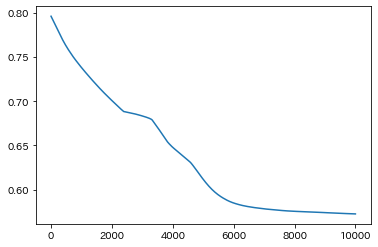

In [99]:
plt.plot(range(len(loss_list)), loss_list)
plt.show()

In [100]:
print(accuracy_score(y_train.detach().cpu().numpy(), pred_train))

0.8518518518518519


In [101]:
pred_df = test[['PassengerId']]
pred_df['Survived'] = pred_test
pred_df.to_csv(DATA_DIR+'dl.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
